In [32]:
import scipy.io
import numpy as np
from scipy.stats import norm
from scipy import signal
from sympy import *
import random
import matplotlib.pyplot as plt
from IPython.display import *
%matplotlib inline

# Importing palmar & lateral

In [33]:
mat1 = scipy.io.loadmat('palmar.mat')
palmar=mat1['palmar']
mat2 = scipy.io.loadmat('lateral.mat')
lateral=mat2['lateral']

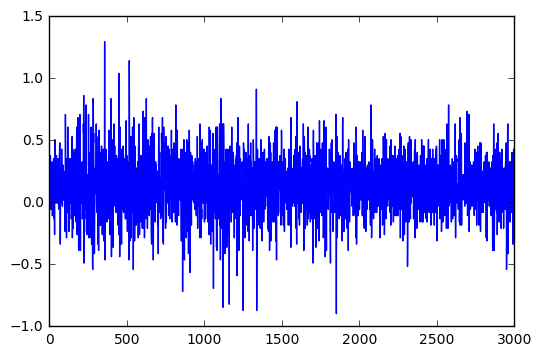

In [34]:
plt.plot(palmar[0,:]) #ploting the first row of palmar before applying filter

# Using Filters

In [35]:
def lfilter(inp, order): # defining Lfilter
    nyq = 1000 / 2.0
    low = 47 / nyq 
    high = 53/ nyq
    b, a = scipy.signal.iirfilter(order,[low,high ], btype='bandstop',ftype='butter')
    output = scipy.signal.lfilter(b, a, inp)
    return output

In [36]:
def iirfilter(inp, order): #defining iirfilter   (we will not use it , putting it for illustration)
    from scipy import signal
    b, a = signal.iirfilter(order, [47/1000, 53/1000], btype='bandstop')
    output = signal.freqs(b, a, inp)
    return output

In [37]:
palmar_filtered=lfilter(inp=palmar,order=6)
lateral_filtered=lfilter(inp=lateral,order=6)

lateral_filtered.shape

(150L, 3000L)

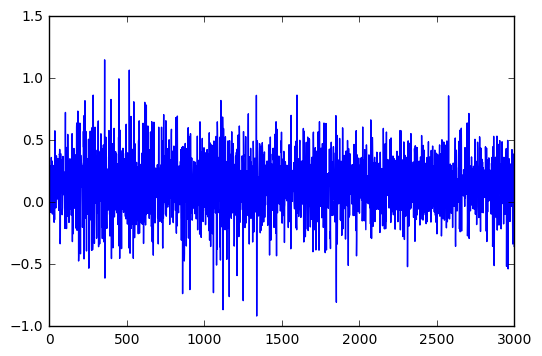

In [38]:
plt.plot(palmar_filtered[0,:]) #ploting the first row of palmar after applying filter

# Extracting Features

In [39]:
def getfeatures(inp):
    
    def feature1(i1):  # feature 1 (energy)
        a=[]            #array for first feature
        squared=i1**2
        for i in squared: 
            s=sum(i)
            a.append(s)
        return a
    def feature2 (i2) : # feature 2 (4th power)
        b=[]           #array for second feature 
        power4=i2**4
        for x in power4: 
            o=sum(x)
            b.append(o)
        return b
    def feature3 (i3):   #feature 3 (Non-linear Energy)
        squared=i3**2
        c=[]           #array for third feature
        k=0    
        for h in range (0,i3.shape[0]):            
            for g in range (2,i3.shape[1]):
                m=-(i3[h,g])*(i3[h,g-2])+squared[h,g-1]
                k += m
            c.append(k)
        return c
    def feature4 (i4):    #feature 4 (curve length)
        
        d=[]          #array for forth feature
        e=0
        for f in range (0,i4.shape[0]):  
            for z in range (1,i4.shape[1]):
                n=i4[f,z]-i4[f,z-1]
                e += n
            d.append(e)
        return d
    
    A=feature1(i1=inp) # calling the small function to be done in the getfeatures function
    B=feature2(i2=inp)
    C=feature3(i3=inp)
    D=feature4(i4=inp)
    
    p=[]  #array contains the features of palmar data
    for i in range (len(inp)):
        u=[A[i],B[i],C[i],D[i]]
        p.append(u)
    final=np.array(p)
    return final

In [40]:
pal_features=getfeatures(inp=palmar_filtered)  # using the palmar output of the filter in extracting features function
lat_features =getfeatures(inp=lateral_filtered)  # using the lateral output of the filter in extracting features function
pal_features.shape   # show the resulted shape from getfeatures function

(150L, 4L)

# Spliting Data

In [41]:
def splitDataset(dataset, splitRatio): # split the given Data into 2 parts (trainset and testset)
    trainSize = int(len(dataset) * splitRatio)
    trainSet = []
    testSet = list(dataset)
    while len(trainSet) < trainSize:
        index = random.randrange(len(testSet)) # we use this random function to put each signal in a random way in each of test and train
        trainSet.append(testSet.pop(index))    # actually we get dispense using this function by using just the while then "trainSet.append(testSet.pop())"
    train=np.array(trainSet)
    test=np.array(testSet)
    return train, test

In [42]:
palmar_train ,palmar_test=splitDataset(dataset=pal_features,splitRatio=0.67) # using the output of getfeature function in the split function
lateral_train ,lateral_test=splitDataset(dataset=lat_features,splitRatio=0.67)
lateral_test.shape

(50L, 4L)

# Training the data

In [43]:
def mu_std(inp):     # function to get the mean and standard deviation for each columns in the train arrays
    meanOfColumns = np.mean(inp,axis=0)
    std = np.std(inp,axis=0)
    return meanOfColumns,std

In [44]:
palmar_mean,palmar_std= mu_std(inp=palmar_train) # inserting the train array 
lateral_mean,lateral_std=mu_std(inp=lateral_train)
palmar_mean.shape

(4L,)

# Naive Bayes Construction

In [45]:
def posterior_probablity(inp_test, m1, std1, m2, std2): 
    
    empty= np.empty((inp_test.shape[0],inp_test.shape[1]))
    empty2= np.empty((inp_test.shape[0],inp_test.shape[1]))
    evidence= np.empty((inp_test.shape[0]))
    posterior_probablity1= np.empty((inp_test.shape[0]))
    posterior_probablity2= np.empty((inp_test.shape[0]))
    prior=0.5
    
    for h in range (0,inp_test.shape[0]):   # likelihood1
        for g in range (0,inp_test.shape[1]):
            dist=norm(m1[g],std1[g])
            x=dist.pdf(inp_test[h,g])
            empty[h,g] = x
    likelihood1=np.prod(empty,axis=1) # multiply each element in each row with each others (likelihood law)
            
    for k in range (0,inp_test.shape[0]):    # likelihood1
        for l in range (0,inp_test.shape[1]):
            dist=norm(m2[l],std2[l])
            x2=dist.pdf(inp_test[k,l])
            empty2[k,l] = x2
    likelihood2=np.prod(empty2,axis=1) # multiply each element in each row with each others
 
    for j in range (0,inp_test.shape[0]):    # Evidence
        evidence[j]=likelihood1[j]+likelihood2[j]
    
    
    for u in range (0,inp_test.shape[0]):    # Applying the posterior probablity Rule
        posterior_probablity1[u] =(prior*likelihood1[u])/evidence[u]
        posterior_probablity2[u] =(prior*likelihood2[u])/evidence[u]
        
    return posterior_probablity1 ,posterior_probablity2


In [46]:
p1,l1=posterior_probablity(inp_test=palmar_test,m1=palmar_mean,std1=palmar_std,m2=lateral_mean,std2=lateral_std) 
# p1 is the posterior probablity of the test array to be palmar  ,l1 is the posterior probablity of the test array to be lateral
p2,l2=posterior_probablity(inp_test=lateral_test,m1=palmar_mean,std1=palmar_std,m2=lateral_mean,std2=lateral_std)
# p2 is the posterior probablity of the test array to be palmar  ,l2 is the posterior probablity of the test array to be lateral

# Making Decisions

In [47]:
def pcompare (inp1 ,inp2): # if u entered the palmar_test from the first (in posterior_probablity)
    z=[]
    for i in range(0,len(inp1)):
        if (inp1[i]>inp2[i]):
            c=1                #palmar
        elif (inp1[i]<inp2[i]):
            c=0                 #lateral
        else:
            c=2                 
        z.append(c) 
    return z
def lcompare (inp1 ,inp2): # if u are working on lateral test list
    z=[]
    for i in range(0,len(inp1)):
        if (inp1[i]>inp2[i]):
            c=0                  #palmar
        elif (inp1[i]<inp2[i]):
            c=1             #lateral 
        else:
            c=2                           
        z.append(c) 
    return z

In [48]:
final1=pcompare(inp1=p1, inp2=l1)  # inserting the posterior proabablity of palmar and that of lateral given palmar_test
final2=lcompare(inp1=p2 , inp2 =l2) # inserting the posterior proabablity of palmar and that of lateral given lateral_test

# Classifier performance

In [49]:
def getAccuracy(inp):    # classifier performance
    correct = 0
    for x in range(len(inp)):
        if inp[x] == 1: 
            correct += 1
    return (correct/float(len(inp))) * 100.0

In [50]:
my_accuracy1=getAccuracy(inp=final1)
my_accuracy2=getAccuracy(inp=final2)
print 'if we used the palmar_test :{v}'.format (v=my_accuracy1)
print 'if we used the lateral_test :{v}'.format (v=my_accuracy2)

if we used the palmar_test :82.0
if we used the lateral_test :98.0
